## Appendix 3
**Abstractable Text Summarization Using fine-tined T5-small Text-To-Text model**

The Python notebook demonstrates the usage of a fine-tuned T5-small model for summary generation. The T5-small model is a smaller variant of the T5 (Text-to-Text Transfer Transformer) architecture, known for its versatility in various NLP tasks. By fine-tuning the model on a specific summarization dataset, the notebook showcases how to effectively generate concise and coherent summaries from longer text inputs. This approach demonstrates the power of transformer models and their adaptability for a range of NLP applications.

In [ ]:
#importing google drive 
from google.colab import drive

In [ ]:
#installing necessary libraries 
!pip install torch
!pip install transformers
!pip install pandas
!pip install sentencepiece==0.1.94

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [ ]:
#importing neccesary libraires
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from tqdm import tqdm
import transformers
from transformers import get_linear_schedule_with_warmup  # Import the get_linear_schedule_with_warmup function


In [ ]:
#mounting the drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#listing out the files in drive
!ls "/content/drive/My Drive/df_merged.csv"

'21 CV.gdoc'
'243 Analytics Lab_Powerpoint.pptx'
 243PRES_m2.gslides
 290_HW4.gdoc
 A2-Q1.drawio
 A2-Q2.drawio
 alexar-test.zip
 Ankur-DV.pdf
 Ankur_IV.docx
'Ankur Kumar Comprehensive Exam.gdoc'
'Ankur Kumar Comprehensive Exam.pdf'
 Ankur.pdf
 Ankur_Resume_GD.docx
 Ankur_Resume_Kone.docx
 Ankur_Resume_MC.docx
 Ankur_Resume_SD.docx.pdf
'Assignment 1: Optimization.gdoc'
 Atomic-Memo.gdoc
 Billy_Lin_Resume_Firmware.docx
'Colab Notebooks'
 Conf_Review.drawio
 CONF_REVIEW.drawio
'Copy Hanwha of Copy of Billy_Lin_Resume_Firmware.docx'
 Data
 Database_A2.docx
 Database_A4.docx
 df_merged.csv
 df_split1_clean.csv
 df_split1_clean.gsheet
 Discussion2.drawio
 Fine_Tuned_DL_Model_Better.ipynb
'Hanwha Resume.pdf'
'Healthcare HW5.gdoc'
 Homework1_Database.docx
'Homework 3.docx'
'JPEG image.jpeg'
 model.pt
 Optimization_A2.gdoc
 Primal_Cap_CV.gdoc
'Progress Report.gdoc'
 Q3_290.gdoc
 TarunAllaparti_Resume_data.docx
 Tie_CV.gdoc
'Train Data'
'Untitled Diagram (1).drawio'
'Untitled Diagram.drawio'
'Un

In [ ]:
# loading the dataset
df = pd.read_csv("/content/drive/My Drive/Data/df_merged.csv", dtype='str')

In [ ]:
# dropping the reindexed column from the summary data 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head(5)

,Text,Summary
0,"This post is part of Polyarchy, an independent...",['In the wake of a New York Times article sugg...
1,The Indianapolis Colts made Andrew Luck the h...,['The Indianapolis Colts made Andrew Luck the ...
2,"DAVOS, Switzerland (Reuters) - U.S. President ...","[""The special counsel investigating alleged Ru..."
3,PARIS (Reuters) - Former French president Nico...,['Sarkozy has retired twice from politics - th...
4,Paris Hilton arrived at LAX Wednesday dressed ...,['Paris Hilton arrived at LAX Wednesday dresse...


In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [ ]:
#storing dfs in variables for easier use
processed_text = pd.DataFrame(text_strip(df['Text']))
processed_summary = pd.DataFrame(text_strip(df['Summary']))

In [ ]:
df_test = df.sample(n = 1000)

In [ ]:
def word_count(dataframe, column_name):
    # Split the text in the specified column into words
    words = dataframe[column_name].str.split()
    
    # Count the number of words in each row
    counts = words.apply(lambda x: len(x))
    
    # Add the new column to the DataFrame
    dataframe['word_count'] = counts
    
    return dataframe

df_test = word_count(df_test, 'Summary')

In [ ]:
#building test set 
df_test = df_test[df_test['word_count'] > 13]

In [ ]:
#resetting the index
df_fine_tune = df_test.reset_index(drop=True)

In [ ]:
#describing the properties 
df_fine_tune.describe()

,word_count
count,731.000000
mean,27.296854
std,29.092215
min,14.000000
25%,18.000000
50%,22.000000
75%,30.000000
max,509.000000


In [ ]:
#checking for null values
df_fine_tune['Text'].isna().values.sum()

0

In [ ]:
#printing 10 articles and summaries
for i in range(10):
  print(df_fine_tune['Text'][i])
  print(df_fine_tune['Summary'][i])

Univision has won the auction for Gawker Media. The TV network and digital publisher has agreed to pay $135 million for the bankrupt blog network, according to a person familiar with the deal. Univision’s offer will encompass all seven of Gawker Media’s sites, including Gawker.com Ziff Davis and Univision were the only two bidders for Gawker, which filed for bankruptcy after Hulk Hogan and Peter Thiel won a $140 million judgment in a privacy case. Ziff Davis had originally offered $90 million for Gawker Media. Here's a statement from Gawker Media owner Nick Denton: "Gawker Media Group has agreed this evening to sell our business and popular brands to Univision, one of America’s largest media companies that is rapidly assembling the leading digital media group for millennial and multicultural audiences. I am pleased that our employees are protected and will continue their work under new ownership — disentangled from the legal campaign against the company. We could not have picked an acq

The given code defines a custom dataset class, FineTuneDataset, for fine-tuning a transformer model on a summarization task. The class inherits from the PyTorch Dataset class and includes the following methods and attributes:

__init__(self, data, tokenizer, max_length): Initializes the dataset class with three arguments: the data to be used for training, the tokenizer for encoding the text, and the maximum sequence length for tokenized sequences.

__len__(self): Returns the total number of samples in the dataset by implementing the len() function for the dataset object.

__getitem__(self, index): Allows the dataset to be indexed, returning a single sample at the specified index. This method performs several operations:

- Retrieves the article and summary texts from the dataset using the provided index.
- Tokenizes and encodes the article and summary texts using the provided   tokenizer and the specified maximum sequence length.
- Extracts the input IDs and attention mask from the tokenizer's output.
- Creates decoder input IDs by cloning the input IDs and setting the first token to the BOS (beginning-of-sentence) token ID.
- Creates labels for the model by cloning the decoder input IDs and setting padding tokens to -100 (ignored by the loss function).
- Returns a dictionary containing the input IDs, attention mask, decoder input IDs, and labels for the current sample.

In [ ]:
class FineTuneDataset(Dataset):  # Define a custom dataset class that inherits from PyTorch's Dataset class
    def __init__(self, data, tokenizer, max_length):  # Initialize the class with data, tokenizer, and max_length arguments
        self.tokenizer = tokenizer  # Store the tokenizer
        self.data = data  # Store the data
        self.max_length = max_length  # Store the maximum sequence length

        # Set the beginning-of-sentence (BOS) token ID
        if self.tokenizer.bos_token_id is None:
            self.bos_token_id = self.tokenizer.convert_tokens_to_ids('[CLS]')
        else:
            self.bos_token_id = self.tokenizer.bos_token_id

    def __len__(self):  # Define the length method to return the number of data samples
        return len(self.data)

    def __getitem__(self, index):  # Define the getitem method to return a single data sample
        article = self.data.iloc[index]['Text']  # Get the article text from the data
        summary = self.data.iloc[index]['Summary']  # Get the summary text from the data

        # Tokenize and encode the article and summary texts
        inputs = self.tokenizer.encode_plus(
            article,
            summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        # Extract the input IDs and attention mask from the tokenizer's output
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        # Create decoder input IDs by cloning the input IDs and setting the first token to the BOS token ID
        decoder_input_ids = input_ids.clone()
        decoder_input_ids[0] = self.bos_token_id

        # Create the labels by cloning the decoder input IDs and setting padding tokens to -100 (ignored by the loss function)
        labels = decoder_input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Return a dictionary containing input IDs, attention mask, decoder input IDs, and labels
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'decoder_input_ids': decoder_input_ids,
            'labels': labels
        }


In [ ]:
#setting max length of the tokenizer 
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)


In [ ]:
#loading up PyTorch dataloader
dataset = FineTuneDataset(df_fine_tune, tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')  # Load a pretrained T5-small model for conditional text generation
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)  # Create an AdamW optimizer with a learning rate of 1e-4 for model parameters


In [ ]:
transformers.logging.set_verbosity_error()  # Set transformers logging level to "error" to suppress less important messages

num_training_steps = len(dataloader) * 3  # Calculate the total number of training steps (length of dataloader multiplied by the number of epochs)
num_warmup_steps = int(0.1 * num_training_steps)  # Set 10% of the total training steps as warmup steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)  # Create a linear learning rate scheduler with warmup steps


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #make the google collab notebook use gpu if available


In [ ]:
#make lists for epochs and average_loss
epochs = []
average_loss = []

This is the main training loop for fine-tuning the model. It runs for 5 epochs, iterating through each batch in the dataloader, performing forward and backward passes, updating model parameters printing the average loss per epoch. 

In [ ]:
for epoch in range(5):  # Run the training loop for 5 epochs
    total_loss = 0  # Initialize the total loss for the current epoch
    for batch in dataloader:  # Iterate through each batch in the dataloader
        # Move the input data to the device (GPU or CPU) for the current batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        decoder_input_ids = batch['decoder_input_ids'].to(device)
        labels = batch['labels'].to(device)

        model = model.to(device)  # Move the model to the device

        # Perform a forward pass through the model using the input data
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            labels=labels
        )

        loss = outputs[0]  # Extract the loss from the model's output
        loss.backward()  # Perform a backward pass to compute gradients
        optimizer.step()  # Update the model's parameters based on the gradients
        optimizer.zero_grad()  # Zero the gradients for the next iteration
        total_loss += loss.item()  # Add the current batch's loss to the total loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to avoid exploding gradients
        scheduler.step()  # Update the learning rate using the scheduler

    avg_loss = total_loss / len(dataloader)  # Calculate the average loss for the current epoch
    print(f'Epoch {epoch + 1}: average loss = {avg_loss:.4f}')  # Print the average loss for the current epoch
    epochs.append(epoch + 1)  # Append the current epoch number to the epochs list
    average_loss.append(avg_loss)  # Append the average loss to the average_loss list


Epoch 1: average loss = 6.7919
Epoch 2: average loss = 1.9643
Epoch 3: average loss = 0.6492
Epoch 4: average loss = 0.5357
Epoch 5: average loss = 0.5318


In [ ]:
torch.save(model.state_dict(), 'modelEp51000.pt') #saving the model

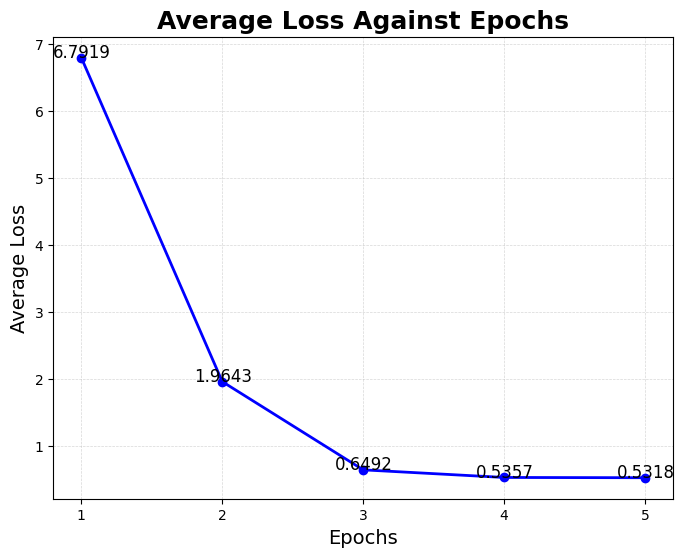

In [ ]:
#graph to visualize average loss against epochs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(epochs, average_loss, marker='o', color='blue', linewidth=2)
ax.set_title('Average Loss Against Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Average Loss', fontsize=14)
ax.set_xticks(epochs)
#x.set_ylim()  # rescale the y-axis
#ax.set_yscale('log')  # set the y-axis scale to logarithmic
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

for x, y in zip(epochs, average_loss):
    ax.annotate(f'{y:.4f}', xy=(x, y), xytext=(x-0.2, y+0.0005), fontsize=12)

plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pt') #saving teh model


In [ ]:
#downloading the model
from google.colab import files
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using the trained model to generate the summary

In [ ]:
model_path = "/content/drive/My Drive/Analytics Lab_INDENG 243 - Project/Module 2/model.pt"
model_dict = torch.load(model_path)
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.load_state_dict(model_dict)
tokenizer = T5Tokenizer.from_pretrained('t5-small')



# # Initialize the T5-small model and tokenizer
# model = T5ForConditionalGeneration.from_pretrained("t5-small")
# tokenizer = T5Tokenizer.from_pretrained("t5-small")

# # Load the saved state dict into the model
# saved_state_dict = torch.load('modelEp51000.pt')
# model.load_state_dict(saved_state_dict)
model.eval()  # Set the model to evaluation mode

from IPython.display import HTML
HTML("""
<style>
.output {
    overflow-x: auto !important;
}
</style>
""")

# Example news article to summarize
new_article = """A Russian fighter jet has collided with a US drone, causing the unmanned US aircraft to crash into the Black Sea,
the American military says.It says the drone was on a routine mission in international airspace when two Russian jets tried to intercept 
it.The US European Command said the crash on Tuesday was the result of an "unprofessional act by the Russians".US and allied forces will 
continue to operate in the area, it added. There is no word on the incident from Russia."Our MQ-9 aircraft was conducting routine operations 
in international airspace when it was intercepted and hit by a Russian aircraft, resulting in a crash and complete loss of the MQ-9," 
the US statement said.Several times before the collision the Su-27 fighter jets dumped fuel on the drone in a "reckless, 
environmentally unsound and unprofessional manner".MQ-9 Reaper drones are large unmanned aircraft with a 20m (66ft) wingspan designed for 
high-altitude surveillance.Shashank Joshi, defence editor for the Economist magazine, said the Russians may have been trying to intimidate 
the drone as it was hoovering up their communications.White House spokesman John Kirby said Russian intercepts of US aircraft were not uncommon 
over the Black Sea, but it was the first time that one had resulted in a crash.Tensions have risen in the region ever since Russia's annexation 
of Crimea in 2014.Since Russia's full-scale invasion of Ukraine the US and the UK have stepped up reconnaissance and surveillance flights, 
though always operating in international airspace."""
max_summary_len = 500

input_text = "summarize: " + new_article[:512].strip()
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_ids = input_ids.to(model.device)

summary_ids = model.generate(
    input_ids=input_ids,
    num_return_sequences=1,
    max_length=max_summary_len,
    #max_new_tokens=max_summary_len,
    num_beams=4,
    #num_beam_groups=3,
    no_repeat_ngram_size=3,
    temperature=0.7,
    length_penalty=2.0,
    early_stopping=True,
)


summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)

from IPython.display import display, HTML

# Create a string with the summary variable
summary_str = "Generated summary: " + summary

words = summary_str.split()
k = []
for i in words:
    if summary_str.count(i)>=1 and i not in k:
        if i.endswith('s') and i[:-1] in k:
            continue
        k.append(i)

summary_str = (' '.join(k))


# Wrap the string in a <div> tag with a CSS style to prevent horizontal scrolling
display(HTML('<div style="white-space: pre-wrap;">' + summary_str + '</div>'))


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Model Evaluation 

In [ ]:
#installing rouge for model evaluation 
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge  # Import the Rouge library for evaluating summarization performance

# Select a sample of 10 articles from the fine-tuning dataset
sample = df_fine_tune[0:10]
rouge_scores = []  # Initialize a list to store ROUGE scores
cnt = 0  # Initialize a counter
generated_summary = []  # Initialize a list to store generated summaries

# Iterate through the indices of the sample articles
for i in sample.index:
    new_article = sample['Text'][i]  # Retrieve the article text

    # Create input text for the model by concatenating 'summarize: ' and the truncated article text
    input_text = "summarize: " + new_article[:512].strip()
    input_ids = tokenizer.encode(input_text, return_tensors='pt')  # Encode the input text
    input_ids = input_ids.to(model.device)  # Move the input IDs to the device

    # Generate a summary using the model with specified settings
    summary_ids = model.generate(
        input_ids=input_ids,
        num_return_sequences=1,
        max_length=max_summary_len,
        num_beams=4,
        no_repeat_ngram_size=3,
        temperature=0.7,
        length_penalty=2.0,
        early_stopping=True,
    )

    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)  # Decode the generated summary

    # Create a string with the summary variable
    summary_str = "Generated summary: " + summary

    # Remove duplicate words from the summary
    words = summary_str.split()
    k = []
    for i in words:
        if summary_str.count(i) >= 1 and i not in k:
            if i.endswith('s') and i[:-1] in k:
                continue
            k.append(i)
    summary_str = (' '.join(k))

    # Compute the ROUGE scores and store them in a list
    rouge = Rouge()
    scores = rouge.get_scores(summary_str, sample['Summary'][cnt], avg=True)
    rouge_scores.append(scores)
    cnt += 1

    generated_summary.append(summary_str)

    # Print the article and generated summary, wrapping them in HTML for readability
    print('Article:')
    display(HTML('<div style="white-space: pre-wrap;">' + new_article + '</div>'))
    print('\n')
    display(HTML('<div style="white-space: pre-wrap;">' + summary_str + '</div>'))
    print('\n')


Article:




Article:




Article:




Article:




Article:




Article:




Article:




Article:




Article:




Article:


In [ ]:
#rouge_scores

In [ ]:
scores = rouge.get_scores(generated_summary[3], sample['Summary'][3], avg=True)

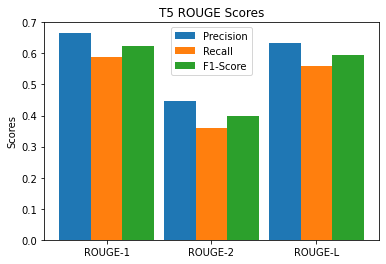

In [ ]:
import matplotlib.pyplot as plt

# Create bar chart of ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
precision_scores = [scores["rouge-1"]["p"], scores["rouge-2"]["p"], scores["rouge-l"]["p"]]
recall_scores = [scores["rouge-1"]["r"], scores["rouge-2"]["r"], scores["rouge-l"]["r"]]
f1_scores = [scores["rouge-1"]["f"], scores["rouge-2"]["f"], scores["rouge-l"]["f"]]

x = range(len(labels))
width = 0.3

fig, ax = plt.subplots()
precision_bars = ax.bar(x, precision_scores, width, label='Precision')
recall_bars = ax.bar([i + width for i in x], recall_scores, width, label='Recall')
f1_bars = ax.bar([i + width*2 for i in x], f1_scores, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('T5 ROUGE Scores')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()